## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [2]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

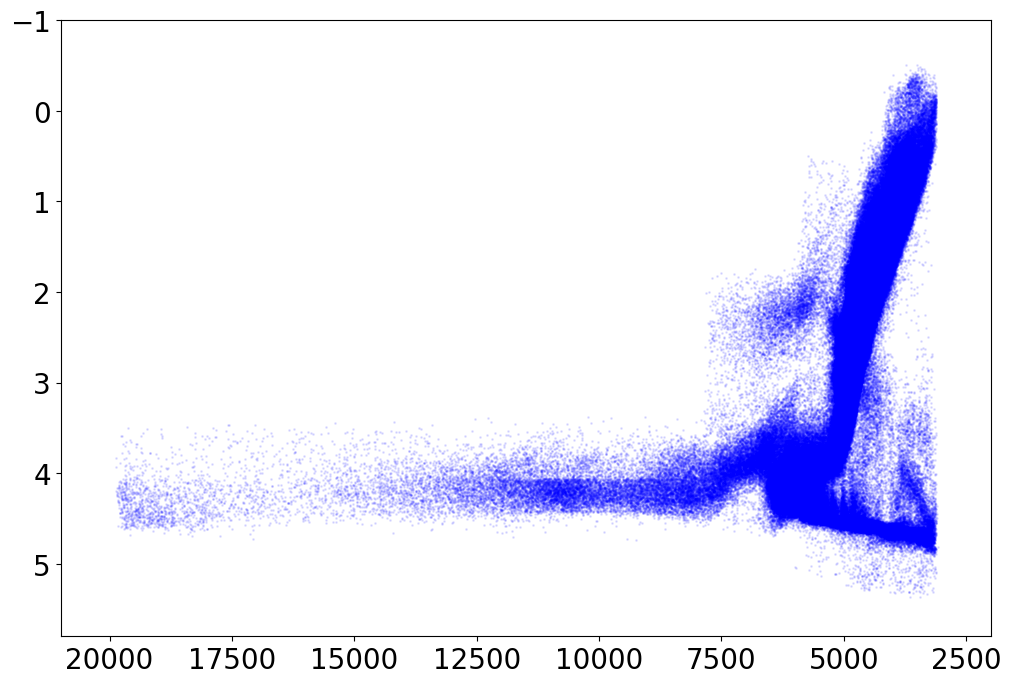

In [8]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

POLY2: -0.074, -0.317, 0.048
POLY3: 0.075, 0.093, -0.262,0.045
LINEAR: -0.233, 0.054


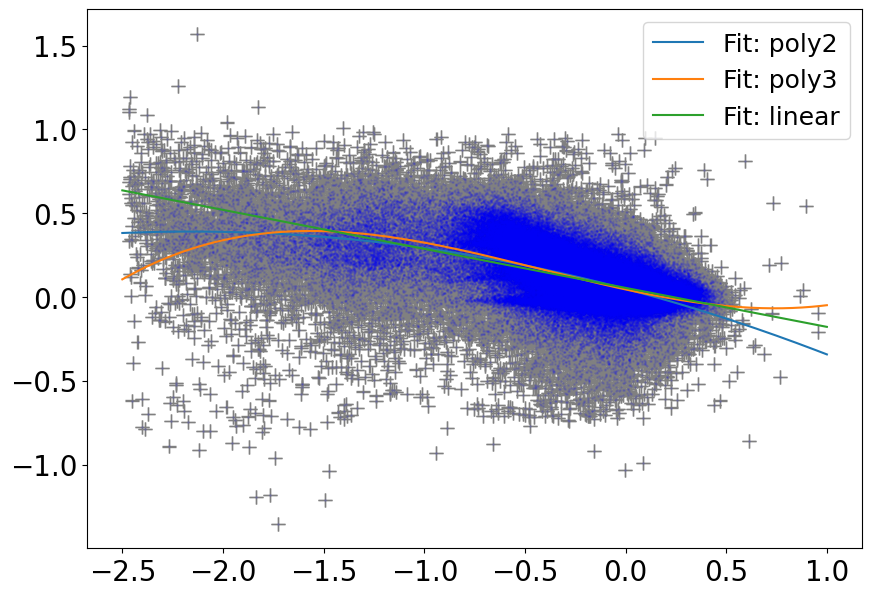

In [14]:
# write your fitting code, from part 1, and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['FE_H']) &\
      ~np.isnan(star['O_FE']) &\
      (star['GLAT'] > 20) &\
      (star['FE_H'] != -9999) & \
      (star['FE_H'] != 9999) & \
      (star['O_FE'] != -9999) & \
      (star['O_FE'] != 9999 )
cut1 = np.where(ct1)[0]
#      (star['FE_H']) != -9999 & \
#      (star['FE_H']) != 9999 & \
#      (star['O_FE']) != -9999 & \
#      (star['O_FE']) != 9999 & (star['GLAT'] > 20) 
#=================================================================================

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1], star['O_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                         star['FE_H_ERR'][cut1]/1000,p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## POLY3 FIT (4 parameter)
polyD, polyE, polyF, polyG = mcFit4(poly3,star['FE_H'][cut1], star['O_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                         star['FE_H_ERR'][cut1]/1000, p0=[0,0,0,0])
print(f'POLY3: {polyD:.3f}, {polyE:.3f}, {polyF:.3f},{polyG:.3f}')

#def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
#=================================================================================
slope, intercept = mcFit2(linear, star['FE_H'][cut1], star['O_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                          star['O_FE_ERR'][cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(star['FE_H_ERR'][cut1]/1000),
             yerr=(star['O_FE_ERR'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.5,1,1000) # X-PLOTING FOR FITS

#=================================================================================

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyD, polyE, polyF,polyG ), label='Fit: poly3')
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

POLY2: -0.020, -0.146, 0.041
POLY3: 0.091, 0.131, -0.131,0.033
LINEAR: -0.137, 0.040


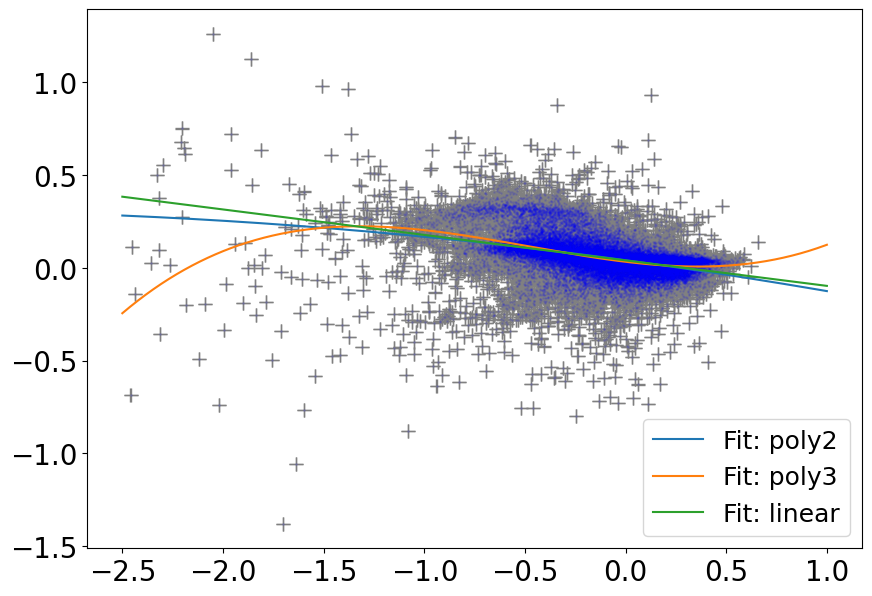

In [22]:
# write your fitting code, from part 1, and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['FE_H']) &\
      ~np.isnan(star['O_FE']) &\
      (star['GLAT'] > -1) &\
      (star['GLAT'] < 1) &\
      (star['FE_H'] != -9999) & \
      (star['FE_H'] != 9999) & \
      (star['O_FE'] != -9999) & \
      (star['O_FE'] != 9999 )
cut1 = np.where(ct1)[0]
#      (star['FE_H']) != -9999 & \
#      (star['FE_H']) != 9999 & \
#      (star['O_FE']) != -9999 & \
#      (star['O_FE']) != 9999 & (star['GLAT'] > 20) 
#=================================================================================

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1], star['O_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                         star['FE_H_ERR'][cut1]/1000,p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## POLY3 FIT (4 parameter)
polyD, polyE, polyF, polyG = mcFit4(poly3,star['FE_H'][cut1], star['O_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                         star['FE_H_ERR'][cut1]/1000, p0=[0,0,0,0])
print(f'POLY3: {polyD:.3f}, {polyE:.3f}, {polyF:.3f},{polyG:.3f}')

#def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
#=================================================================================
slope, intercept = mcFit2(linear, star['FE_H'][cut1], star['O_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                          star['O_FE_ERR'][cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(star['FE_H_ERR'][cut1]/1000),
             yerr=(star['O_FE_ERR'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.5,1,1000) # X-PLOTING FOR FITS

#=================================================================================

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyD, polyE, polyF,polyG ), label='Fit: poly3')
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

[4.2945533 4.381504  4.517992  ... 4.3983607 4.528487  4.556428 ]
exponential: -25.000, -25.000, -25.000,1.820 
POLY3: 0.000, -0.000, 0.002,-4.057
LINEAR: 0.000, 0.347


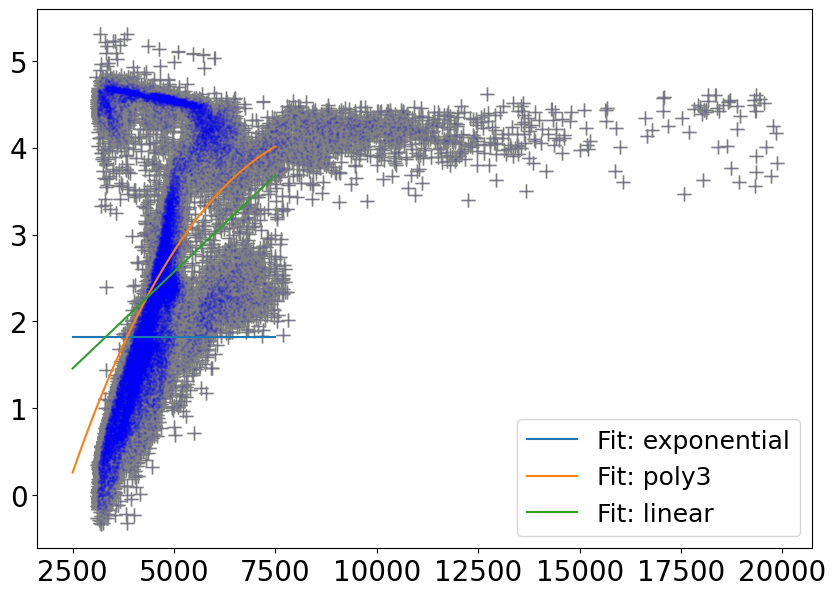

In [23]:
# write your fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['TEFF']) &\
      ~np.isnan(star['LOGG']) &\
      (star['GLON'] > 340) &\
      (star['GLON'] < 360)&\
      (star['TEFF'] != -9999) & \
      (star['TEFF'] != 9999) & \
      (star['LOGG'] != -9999) & \
      (star['LOGG'] != 9999 )
ct2 = (star['TEFF'] > 2500) &\
      (star['TEFF']< 5000) &\
      (star['LOGG'] > 0) &\
      (star['LOGG'] <4) &\
      (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['TEFF']) &\
      ~np.isnan(star['LOGG']) &\
      (star['GLON'] > 340) &\
      (star['GLON'] < 360)&\
      (star['TEFF'] != -9999) & \
      (star['TEFF'] != 9999) & \
      (star['LOGG'] != -9999) & \
      (star['LOGG'] != 9999 )
cut1 = np.where(ct1)[0]
cut2 = np.where(ct2)[0]
#      (star['FE_H']) != -9999 & \
#      (star['FE_H']) != 9999 & \
#      (star['O_FE']) != -9999 & \
#      (star['O_FE']) != 9999 & (star['GLAT'] > 20) 
#=================================================================================

#=================================================================================
print(star['LOGG'][cut1])
## EXPONENTIAL FIT (4 parameter)
polyA, polyB, polyC,polyC1  = mcFit4(exponential, star['TEFF'][cut2], star['LOGG'][cut2], star['TEFF_ERR'][cut2]/1000, \
                         star['LOGG_ERR'][cut2]/1000,p0=[-25,-25,-25,-25])
print(f'exponential: {polyA:.3f}, {polyB:.3f}, {polyC:.3f},{polyC1:.3f} ')

## POLY3 FIT (4 parameter)
polyD, polyE, polyF, polyG = mcFit4(poly3,star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1]/1000, \
                         star['LOGG_ERR'][cut1]/1000, p0=[0,0,0,0])
print(f'POLY3: {polyD:.3f}, {polyE:.3f}, {polyF:.3f},{polyG:.3f}')


#=================================================================================
slope, intercept = mcFit2(linear, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1]/1000, \
                          star['LOGG_ERR'][cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],star['LOGG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1]),star['LOGG'][cut1], xerr=(star['TEFF_ERR'][cut1]/1000),
             yerr=(star['LOGG_ERR'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(2500,7500,1000) # X-PLOTING FOR FITS

#=================================================================================

#exponential fit
ax1.plot(x_plot,exponential(x_plot, polyA, polyB, polyC,polyC1 ), label='Fit: exponential')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyD, polyE, polyF,polyG ), label='Fit: poly3')
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

POLY2: 0.000, -0.001, 3.066


/var/folders/8n/_zsxbt555mg2xb2p3pskzrjh0000gn/T/ipykernel_702/982337099.py:23: RuntimeWarning: divide by zero encountered in log
  return a*np.log(b*x + c) + d
/var/folders/8n/_zsxbt555mg2xb2p3pskzrjh0000gn/T/ipykernel_702/982337099.py:23: RuntimeWarning: invalid value encountered in multiply
  return a*np.log(b*x + c) + d
/Users/panda.dk/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


LOGFIT: 0.000, 0.000, 0.000,0.000
LINEAR: -0.000, 1.910


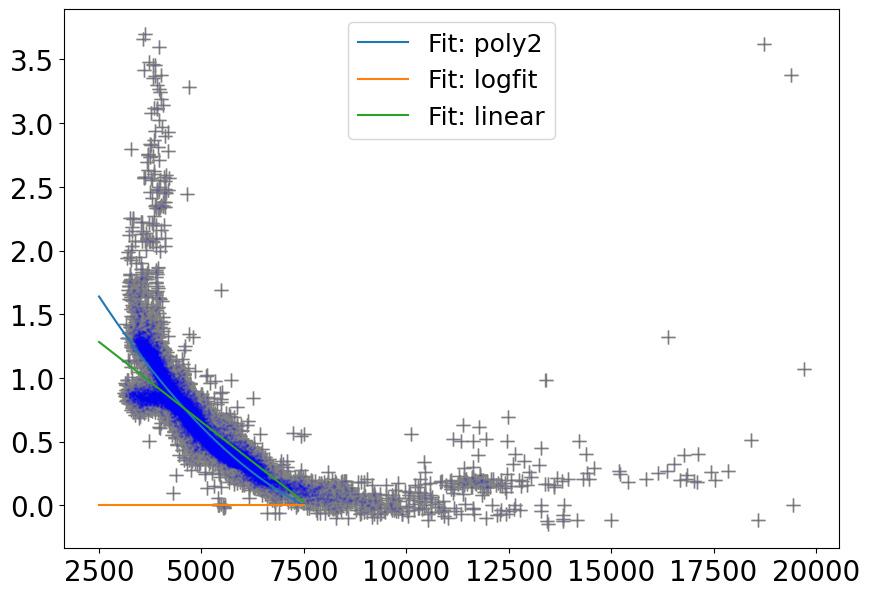

In [4]:
# write your fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters
              
#file = open ("miniDR17.fits",'a')
JK = star['J'] - star['K']
JK_ERR = np.sqrt(star['J_ERR']**2 + star['K_ERR']**2)
#file.write(JK)
#file.write(JK_ERR)
#file.close
#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['TEFF']) &\
      (star['RA'] > 50) &\
      (star['RA'] < 120) &\
      (star['DEC'] < -50) &\
      (star['TEFF'] != -9999) & \
      (star['TEFF'] != 9999) & \
      ~np.isnan(JK) & \
      ~np.isnan(JK_ERR) &\
      (JK != -9999) & \
      (JK != 9999) 
cut1 = np.where(ct1)[0]
#      (star['FE_H']) != -9999 & \
#      (star['FE_H']) != 9999 & \
#      (star['O_FE']) != -9999 & \
#      (star['O_FE']) != 9999 & (star['GLAT'] > 20) 
#=================================================================================

#=================================================================================

## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['TEFF'][cut1], JK[cut1], star['TEFF_ERR'][cut1]/1000, \
                         JK_ERR[cut1]/1000,p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## log FIT (4 parameter)
polyD, polyE, polyF, polyG = mcFit4(logfit,star['TEFF'][cut1], JK[cut1], star['TEFF_ERR'][cut1]/1000, \
                         JK_ERR[cut1]/1000, p0=[0,0,0,0])
print(f'LOGFIT: {polyD:.3f}, {polyE:.3f}, {polyF:.3f},{polyG:.3f}')

## Linear Fit(2parameters)
#=================================================================================
slope, intercept = mcFit2(linear, star['TEFF'][cut1], JK[cut1], star['TEFF_ERR'][cut1]/1000, \
                          JK_ERR[cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],JK[cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1]),JK[cut1], xerr=(star['TEFF_ERR'][cut1]/1000),
             yerr=(JK_ERR[cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(2500,7500,1000) # X-PLOTING FOR FITS

#=================================================================================

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='Fit: poly2')
#log fit
ax1.plot(x_plot,poly3(x_plot, polyD, polyE, polyF,polyG ), label='Fit: logfit')
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

[3.6739705 3.7155607 3.456132  ... 2.474665  2.4806874 2.571437 ]
Cosfit: 49.851, 0.023, -5.423,0.598 
POLY3: -0.000, 0.000, -0.004,3.435
LINEAR: 0.000, -5.504


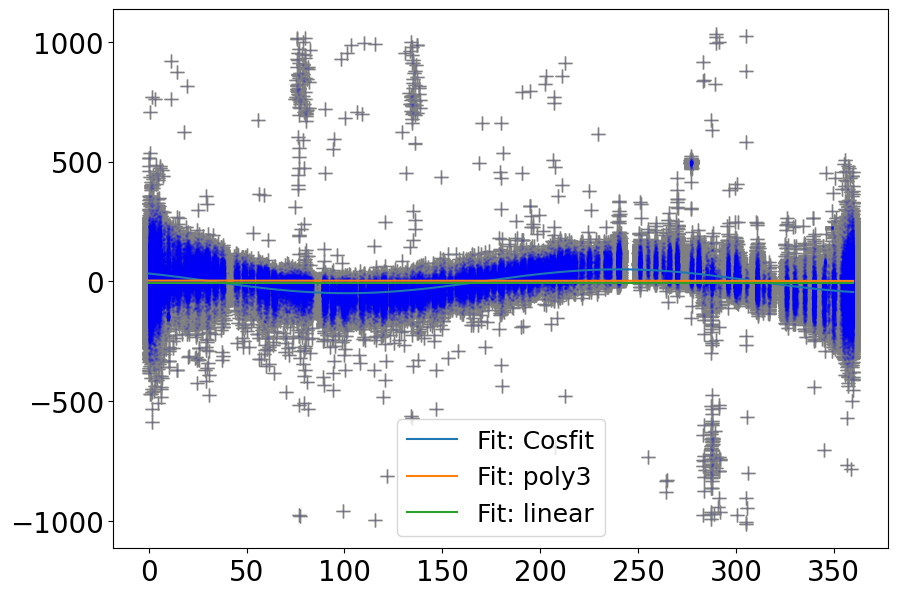

In [45]:
# write your fitting code and plot the results here
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['TEFF']) &\
      ~np.isnan(star['LOGG']) &\
      (star['GLAT'] > -10) &\
      (star['GLAT'] < 10)&\
      (star['GLON'] != -9999) & \
      (star['GLON'] != 9999) & \
      (star['VHELIO_AVG'] != -9999) & \
      (star['VHELIO_AVG'] != 9999 )
cut1 = np.where(ct1)[0]
#      (star['FE_H']) != -9999 & \
#      (star['FE_H']) != 9999 & \
#      (star['O_FE']) != -9999 & \
#      (star['O_FE']) != 9999 & (star['GLAT'] > 20) 
#=================================================================================

#=================================================================================
print(star['LOGG'][cut1])
## COS FIT (4 parameter)
polyA, polyB, polyC,polyC1  = mcFit4(cosfit, star['GLON'][cut1], star['VHELIO_AVG'][cut1],star['GLON'][cut1]== 0, \
                         star['VERR'][cut1]/1000,p0=[8,0.01,-2.3,1.8])
print(f'Cosfit: {polyA:.3f}, {polyB:.3f}, {polyC:.3f},{polyC1:.3f} ')

## POLY3 FIT (4 parameter)
polyD, polyE, polyF, polyG = mcFit4(poly3,star['TEFF'][cut1], star['VHELIO_AVG'][cut1],star['GLON'][cut1]== 0,\
                         star['VERR'][cut1]/1000, p0=[-3.28e-05,1.72e-02,-2.2,40.5])
print(f'POLY3: {polyD:.3f}, {polyE:.3f}, {polyF:.3f},{polyG:.3f}')


#=================================================================================
slope, intercept = mcFit2(linear, star['TEFF'][cut1], star['VHELIO_AVG'][cut1],star['GLON'][cut1]==0,\
                          star['VERR'][cut1]/1000, p0=[-7.54e-03,-4.07])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['GLON'][cut1],star['VHELIO_AVG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['GLON'][cut1]),star['VHELIO_AVG'][cut1], xerr=(star['GLON'][cut1]==0),
             yerr=(star['VERR'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)

#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================

#Cos fit
ax1.plot(x_plot,cosfit(x_plot, polyA, polyB, polyC,polyC1 ), label='Fit: Cosfit')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyD, polyE, polyF,polyG ), label='Fit: poly3')
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

EXPONENTIAL: -6.413, -0.365, -0.977,1.790
POLY3: 0.000, -0.019, 0.381,-0.112
LINEAR: 0.107, 0.453


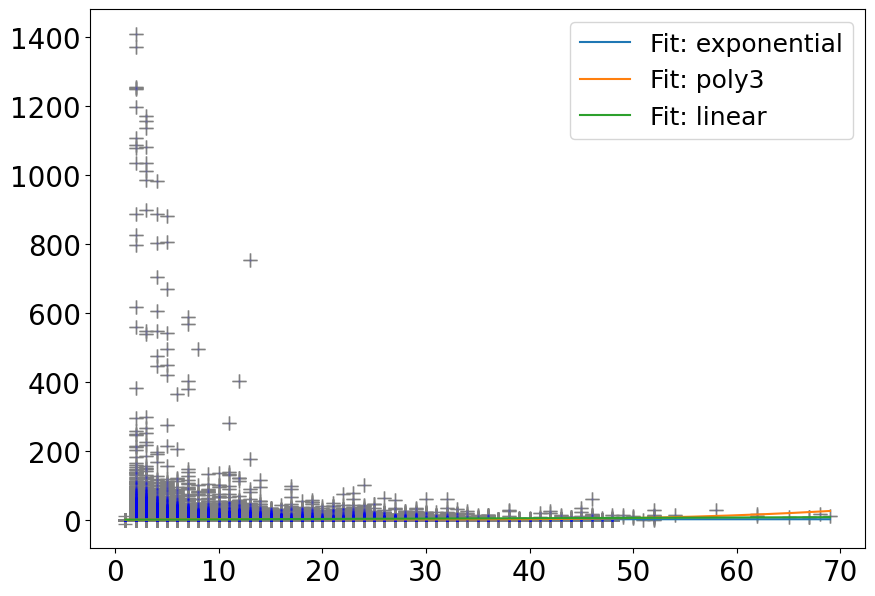

In [10]:
# write your fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['NVISITS']) &\
      ~np.isnan(star['VSCATTER']) &\
      (star['NVISITS'] != -9999) & \
      (star['NVISITS'] != 9999) & \
      (star['VSCATTER'] != -9999) & \
      (star['VSCATTER'] != 9999 )
cut1 = np.where(ct1)[0]
#      (star['FE_H']) != -9999 & \
#      (star['FE_H']) != 9999 & \
#      (star['O_FE']) != -9999 & \
#      (star['O_FE']) != 9999 & (star['GLAT'] > 20) 
#=================================================================================

#=================================================================================
## exponential FIT (3 parameter)
polyA, polyB, polyC,polyC1  = mcFit4(exponential, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['NVISITS'][cut1]==0, \
                         star['VERR'][cut1]/1000,p0=[-4.85,-1.38e-01,-1.23,1.33])
print(f'EXPONENTIAL: {polyA:.3f}, {polyB:.3f}, {polyC:.3f},{polyC1:.3f}')

## POLY3 FIT (4 parameter)
polyD, polyE, polyF, polyG = mcFit4(poly3,star['NVISITS'][cut1], star['VSCATTER'][cut1], star['NVISITS'][cut1]==0, \
                         star['VERR'][cut1]/1000, p0=[0,0,0,0])
print(f'POLY3: {polyD:.3f}, {polyE:.3f}, {polyF:.3f},{polyG:.3f}')

#def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
#=================================================================================
slope, intercept = mcFit2(linear, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['NVISITS'][cut1]==0, \
                          star['VERR'][cut1]/1000, p0=[6.6e-02,1.6e-01])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['NVISITS'][cut1],star['VSCATTER'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['NVISITS'][cut1]),star['VSCATTER'][cut1], xerr=(star['NVISITS'][cut1]==0),
             yerr=(star['VERR'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
#x_plot = np.linspace(0,50,1000) # X-PLOTING FOR FITS
x_plot = np.linspace(np.min(star['NVISITS'][cut1]),np.max(star['NVISITS'][cut1]),1000)
#=================================================================================

#exponential fit
ax1.plot(x_plot,exponential(x_plot, polyA, polyB, polyC,polyC1 ), label='Fit: exponential')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyD, polyE, polyF,polyG ), label='Fit: poly3')
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

POLY2: 0.024, 0.038, 0.017
POLY3: -0.020, -0.017, 0.026,0.018
LINEAR: 0.013, 0.016


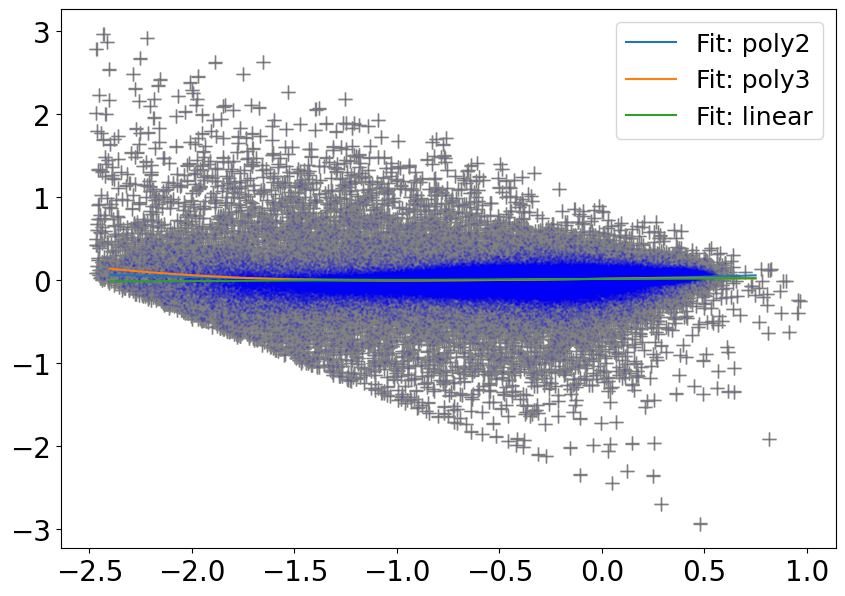

In [6]:
# write your fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      ~np.isnan(star['FE_H']) &\
      ~np.isnan(star['NI_FE']) &\
      (star['FE_H'] != -9999) & \
      (star['FE_H'] != 9999) & \
      (star['NI_FE'] != -9999) & \
      (star['NI_FE'] != 9999 )
cut1 = np.where(ct1)[0]
#      (star['FE_H']) != -9999 & \
#      (star['FE_H']) != 9999 & \
#      (star['O_FE']) != -9999 & \
#      (star['O_FE']) != 9999 & (star['GLAT'] > 20) 
#=================================================================================

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1], star['NI_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                         star['NI_FE_ERR'][cut1]/1000,p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## POLY3 FIT (4 parameter)
polyD, polyE, polyF, polyG = mcFit4(poly3,star['FE_H'][cut1], star['NI_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                         star['NI_FE_ERR'][cut1]/1000, p0=[0,0,0,0])
print(f'POLY3: {polyD:.3f}, {polyE:.3f}, {polyF:.3f},{polyG:.3f}')

#def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
#=================================================================================
slope, intercept = mcFit2(linear, star['FE_H'][cut1], star['NI_FE'][cut1], star['FE_H_ERR'][cut1]/1000, \
                          star['NI_FE_ERR'][cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['NI_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['NI_FE'][cut1], xerr=(star['FE_H_ERR'][cut1]/1000),
             yerr=(star['NI_FE'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.4,0.75,1000) # X-PLOTING FOR FITS

#=================================================================================

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyD, polyE, polyF,polyG ), label='Fit: poly3')
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

plt.legend(loc='best', fontsize=18)
plt.show()